## Plotting a Screening Curve

The below code outlines how to plot a screening curve using the MCMetrics library. The curve is based on the relationship between prevalence of the predicted condition and the positive predictive value of a test or model. A more detailed explanation is included below the figure along with some additional papers.

In [24]:
# import libraries
%cd ../mcmetrics
from main import MCMetrics as mcmetrics
#import MCMetrics as mcmetrics
import numpy as np
import matplotlib.pyplot as plt

c:\Users\cbsit\Dropbox\GitHub\mcmetrics\mcmetrics


In [25]:
# generate some fake data
cm = np.array([[1000, 10], [5, 1000]])  # confusion matrix
class_names = ['Positive', 'Negative']

# initiate model
mc1 = mcmetrics(model_name='screening_curve_model', cm=cm, class_names=class_names)

# sample posterior
mc1.sample(n=100_000)

# calculate sensitivity, specificity, prevalence threshold
mc1.calculate_metric(metric='sensitivity', averaging=None)
mc1.calculate_metric(metric='specificity', averaging=None)
mc1.calculate_metric(metric='prevalence threshold', averaging=None)

<>:65: SyntaxWarning: invalid escape sequence '\p'
<>:65: SyntaxWarning: invalid escape sequence '\p'
C:\Users\cbsit\AppData\Local\Temp\ipykernel_16520\300253490.py:65: SyntaxWarning: invalid escape sequence '\p'
  label='Tangent at $\phi_e$', linestyle='-.',


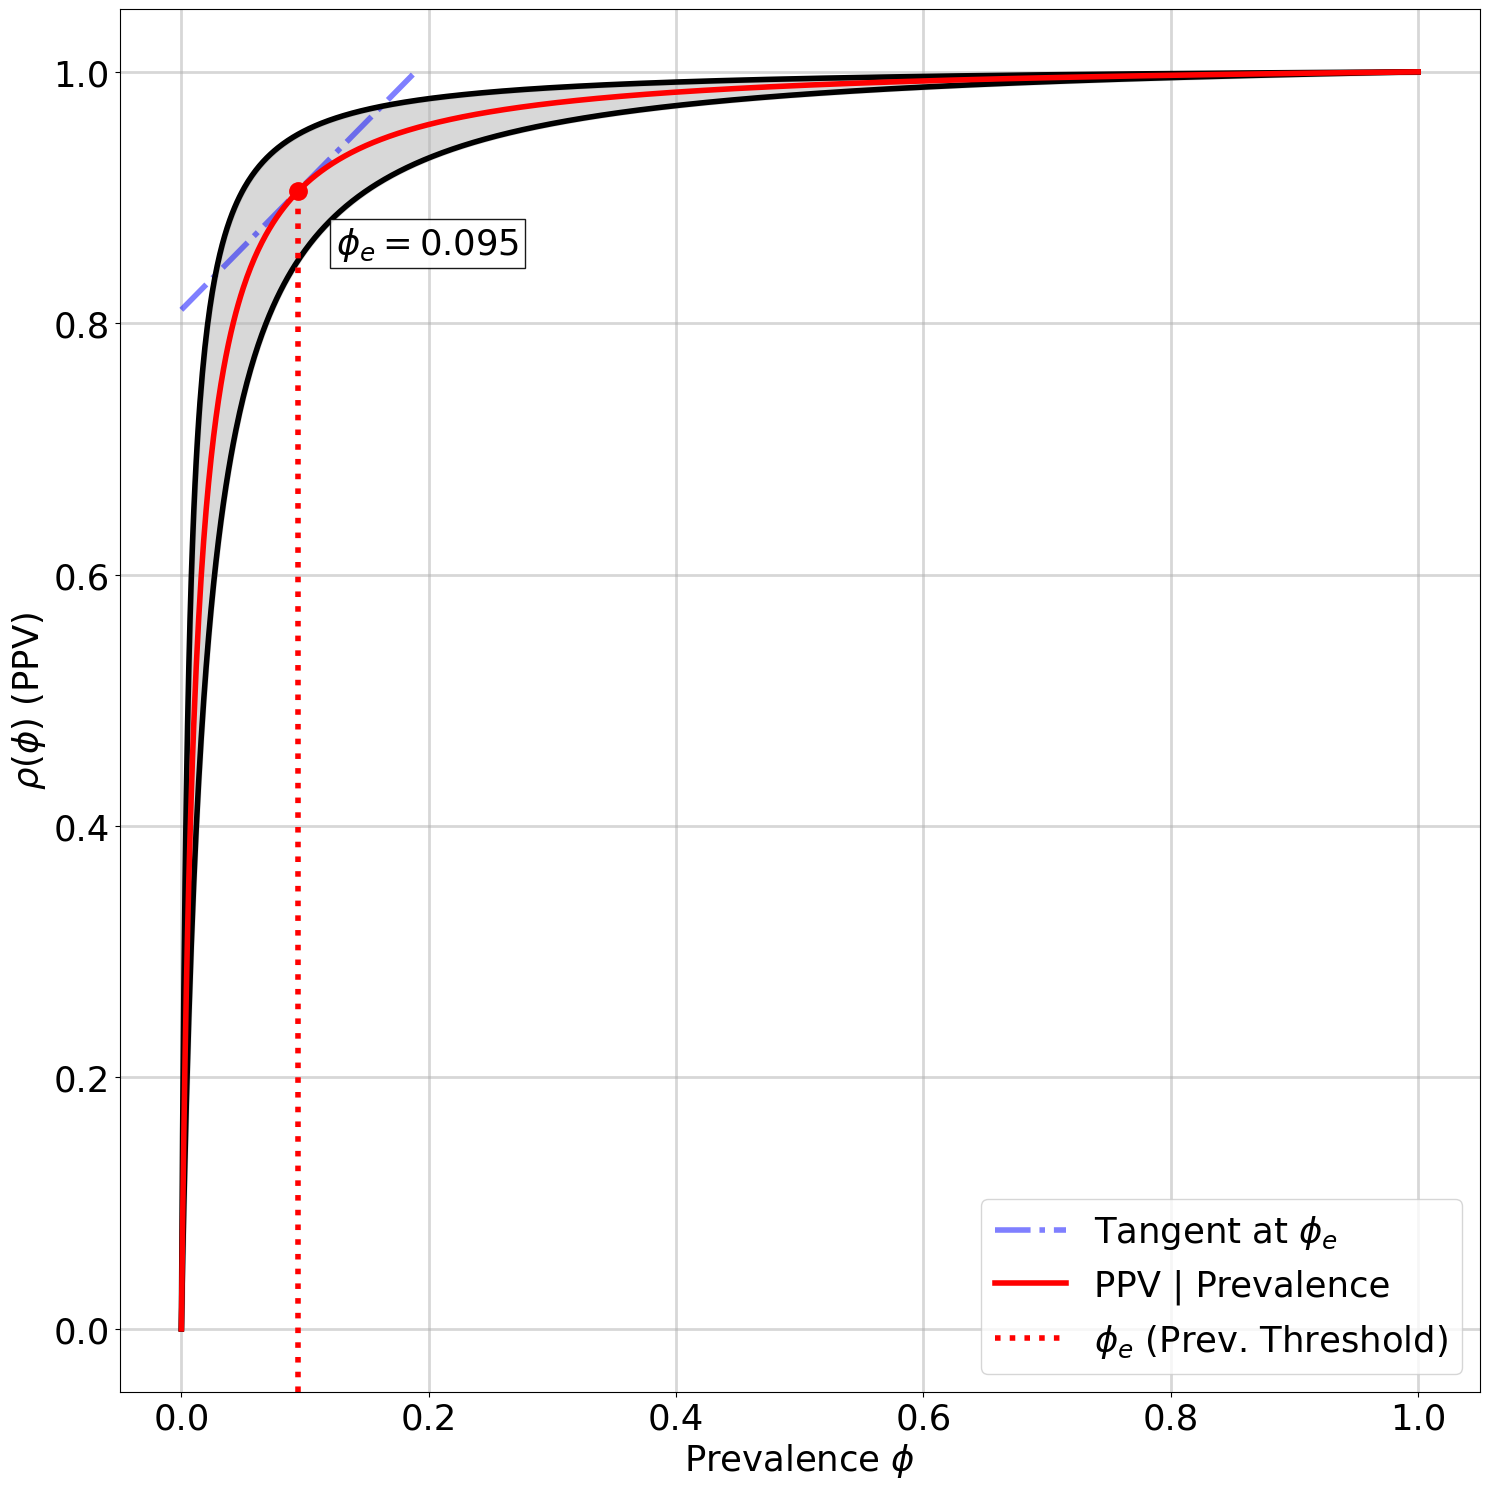

In [28]:
fig_width=15
fig_height=15
font_scale_factor=1.7
ci=0.95
class_ = class_names[0]
dot_line = False    # whether to add the blue dotted tangent line at the prevalence threshold
add_tangent = True  # whether to add the dotted diagonal line at 0.5

### determine phi
phi = np.linspace(0, 1, 1000)

### calculate rho and CIs
### either the mean or mode can be used

sens_m = mc1.calc_mean(metric='sensitivity')
spec_m = mc1.calc_mean(metric='specificity')
#sens_m = mc1.calc_mode(metric='sensitivity')
#spec_m = mc1.calc_mode(metric='specificity')

phi_e = mc1.pt_point_est(sens_=sens_m[class_], spec_=spec_m[class_])
rho_e = mc1.bayes_ppv(sens_m[class_], spec_m[class_], prior=phi_e)

h_ = 1e-8
slope = (mc1.bayes_ppv(sens_m[class_], spec_m[class_], prior=phi_e + h_) - 
         mc1.bayes_ppv(sens_m[class_], spec_m[class_], prior=phi_e - h_)) / (2*h_)

phi_tangent = np.linspace(0, 1, 1000)
rho_tangent = rho_e + slope*(phi_tangent - phi_e)

rho_tangent = np.where(rho_tangent >= 1, np.nan, rho_tangent)
rho_tangent = np.where(rho_tangent <= 0, np.nan, rho_tangent)

# CIs
cil, ciu = mc1.ci_range(ci, ciu=None, cil=None)
sens_cis = mc1.calculate_ci(metric='sensitivity', cil=cil, ciu=ciu)
spec_cis = mc1.calculate_ci(metric='specificity', cil=cil, ciu=ciu)

rho_vals_cil = np.zeros(len(phi))
rho_vals_ciu = np.zeros(len(phi))
rho_vals_mode = np.zeros(len(phi))

for ii, phi_hat in enumerate(phi):
    rho_vals_cil[ii] = mc1.bayes_ppv(sens_cis[class_][0], spec_cis[class_][0], prior=phi_hat)
    rho_vals_ciu[ii] = mc1.bayes_ppv(sens_cis[class_][1], spec_cis[class_][1], prior=phi_hat)
    rho_vals_mode[ii] = mc1.bayes_ppv(sens_m[class_], spec_m[class_], prior=phi_hat)


### Make Plot

plt.figure(figsize=(fig_width, fig_height))

y_axis_font_size = lambda w, h: font_scale_factor * h
y_label_font_size = lambda w, h: font_scale_factor * h
x_label_font_size = lambda w, h: font_scale_factor * h
x_axis_font_size = lambda w, h: font_scale_factor * h
fig_legend_font_size = lambda w, h: font_scale_factor * h
txt_font_size = lambda w, h: font_scale_factor * h
line_widths = lambda w, h: 1 if h <= 7 else 0.2 * h + 1
marker_size = lambda w, h: 5 if h <= 7 else 0.5 * h + 5


# Tangent Line
if add_tangent:
    plt.plot(phi_tangent, rho_tangent, color='blue', alpha=0.5,
            label='Tangent at $\phi_e$', linestyle='-.', 
            linewidth=line_widths(fig_width, fig_height))

# Credible Intervals - Lower
plt.plot(phi, rho_vals_cil, color='black', 
        linewidth=line_widths(fig_width, fig_height))

# Credible Intervals - Upper
plt.plot(phi, rho_vals_ciu, color='black', 
        linewidth=line_widths(fig_width, fig_height))

# Postive predictive value mode
plt.plot(phi, rho_vals_mode, label='PPV | Prevalence', color='red', 
        linewidth=line_widths(fig_width, fig_height))

# fill between the credible intervals
plt.fill_between(phi, rho_vals_cil, rho_vals_ciu, color='grey', 
                alpha=0.3, linewidth=line_widths(fig_width, fig_height))

# add a dotted line at 0.5 if requested
if dot_line:
    plt.plot([0, 1], [0, 1], 'k--', label='0.5 Slope')

# y max adjustment for rho_e
rho_e_max = -1*((rho_e/10)-0.05)

plt.axvline(phi_e, ymin=0, ymax=rho_e+rho_e_max, color='red', 
            linewidth=line_widths(fig_width, fig_height), linestyle=':', label=r'$\phi_e$ (Prev. Threshold)')
#plt.plot(phi_tangent, rho_tangent, color='red', label='Tangent at $\phi_e$')

# Mark the point (phi_e, rho_e) with a dot
plt.plot(phi_e, rho_e, 'ro', markersize=marker_size(fig_width, fig_height))


if np.mean(rho_vals_mode) > 0.5:
    plt.text(phi_e + 0.03, rho_e - 0.05, 
    r'$\phi_e = %.3f$' % phi_e, 
    fontsize=txt_font_size(fig_width, fig_height),
    color='black', bbox=dict(facecolor='white', alpha=0.9))
else:
    plt.text(phi_e - 0.03, rho_e + 0.04,
    r'$\phi_e = %.3f$' % phi_e, 
    fontsize=txt_font_size(fig_width, fig_height),
    color='black', bbox=dict(facecolor='white', alpha=0.9), 
    verticalalignment='bottom', horizontalalignment='right')

plt.yticks(fontsize=y_axis_font_size(fig_width, fig_height))
plt.xticks(fontsize=x_axis_font_size(fig_width, fig_height))

plt.xlabel(r'Prevalence $\phi$', fontsize=x_label_font_size(fig_width, fig_height))
plt.ylabel(r'$\rho(\phi)$ (PPV)', fontsize=y_label_font_size(fig_width, fig_height))

if np.mean(rho_vals_mode) > 0.5:
    plt.legend(loc='lower right', fontsize=fig_legend_font_size(fig_width, fig_height))
else:
    plt.legend(loc='upper left', fontsize=fig_legend_font_size(fig_width, fig_height))

plt.grid(True, alpha=0.5, linewidth=line_widths(fig_width, fig_height)*0.5)

plt.tight_layout()
plt.show()

What the above figure demonstrates is that as the prevalence (x-axis) increases, the test positive predictive value (y-axis) increases. The red dotted line represents the prevalence threshold, marked by a red dot, which is the inflection point on the screening curve (solid red line). The prevalence threshold ($\phi_e$) is defined as:

$$
\phi_e = \frac{\sqrt{a(-b+1)}+b-1}{a+b-1}
$$

Where $a$ is the sensitivity (recall) and $b$ is the specificity (true negative rate) of a test. When $\phi > \phi_e$ the PPV of a screening test increasing by $\frac{1}{\sqrt{\kappa}}$. When $\phi < \phi_e$ the PPV of a screening test decreases by $\sqrt{\kappa}$. Where $\kappa$ is the positive likelihood ratio. In other words, the PPV of a screening test is directly related to the prevalence of what is being measured in a population. It is highly recommended to read the following paper and/or book if you would like to learn more about screening curves, prevalence thresholds, and how they related to Bayesian inference:

Balayla, J. (2020). Prevalence threshold (ϕ e) and the geometry of screening curves. Plos one, 15(10), e0240215.

Balayla, J. (2024). Theorems on the Prevalence Threshold and the Geometry of Screening Curves.